# Homework 6

Chris Kees, March 31 2020

RCSE6830

Instructions: Using a data set provided by the instructor or one selected from either the USGS or USACE databases the student will conduct an effective discharge analysis using the procedures discussed in class.

Specifically the student will:

 - Combine the flow frequency distribution and sediment load rating curves to produce the sediment load histogram, and then identify the Effective Discharge
 - Calculate the range of flows responsible transporting the most sediment; and  
 - Be prepared to discuss your findings in class on April 1, 2020

I'm using data from the Thebes station on the Mississippi River

In [1]:
import pandas
f = pandas.read_table("thebes_daily_data.tsv",header=16).dropna(axis=1,how='all')
f.head()

,agency_cd,site_no,datetime,DAILY_FLOW,DAILY_FLOW_QUAL,DAILY_SSC,DAILY_SSC_QUAL,DAILY_SSL,DAILY_SSL_QUAL
0,USGS,7022000,1933-04-01,191000,A,NaN,NaN,NaN,NaN
1,USGS,7022000,1933-04-02,224000,A,NaN,NaN,NaN,NaN
2,USGS,7022000,1933-04-03,257000,A,NaN,NaN,NaN,NaN
3,USGS,7022000,1933-04-04,279000,A,NaN,NaN,NaN,NaN
4,USGS,7022000,1933-04-05,298000,A,NaN,NaN,NaN,NaN


The time period covered for daily flow is almost 100 years:

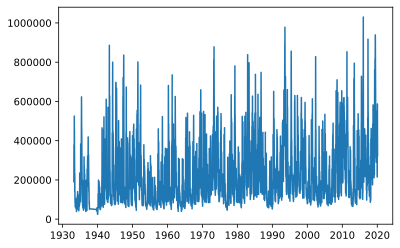

In [2]:
from matplotlib import pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
f.datetime = pandas.to_datetime(f.datetime)
plt.plot(f.datetime,f.DAILY_FLOW);

In [3]:
f2 = pandas.read_table("thebes_discrete_data.tsv",header=52).dropna(axis=1,how='all')
f2.head().dropna(axis=1,how='all')

,SITE_NO,STATION_NM,DATETIME,DCOMMENT,ICOMMENT,SSC,DAILYFLOW,SS,TURB70,TEMPC,SC,DSS,PH
0,7022000,"MISSISSIPPI RIVER AT THEBES, IL",1973-01-30 10:30:00,G,S,306,369000,NaN,NaN,1.5,435.0,NaN,7.8
1,7022000,"MISSISSIPPI RIVER AT THEBES, IL",1973-02-21 10:50:00,G,S,436,237000,NaN,NaN,2.0,430.0,NaN,7.7
2,7022000,"MISSISSIPPI RIVER AT THEBES, IL",1973-06-21 11:00:00,G,S,468,408000,520.0,NaN,25.5,435.0,310.0,7.8
3,7022000,"MISSISSIPPI RIVER AT THEBES, IL",1973-07-18 09:30:00,G,S,227,179000,210.0,50.0,28.0,640.0,370.0,7.8
4,7022000,"MISSISSIPPI RIVER AT THEBES, IL",1973-08-14 10:00:00,G,S,211,208000,130.0,40.0,26.0,545.0,330.0,8.1


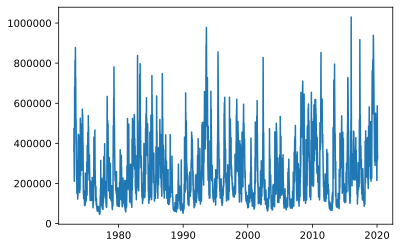

In [4]:
f2.DATETIME = pandas.to_datetime(f2.DATETIME)
(f2.DATETIME.min(),f2.DATETIME.max())
#f.datetime = pandas.to_datetime(f.datetime)
daterange = f.datetime>f2.DATETIME.min()
plt.plot(f.datetime[daterange],f.DAILY_FLOW[daterange]);

# Discharge Histograms for Daily Flow Records

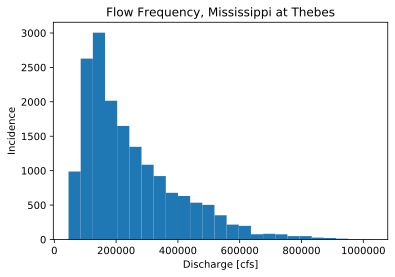

In [5]:
(n,bins,patches) = plt.hist(f.DAILY_FLOW[daterange],bins=25)
plt.ylabel('Incidence')
plt.xlabel('Discharge [cfs]');
plt.title("Flow Frequency, Mississippi at Thebes");
plt.savefig("freq.png")

In [6]:
annual_frequency = 365.0*n/n.sum()
rep_discharge = 0.5*(bins[0:-1] + bins[1:])

In [7]:
import numpy as np
flow=[]
sand=[]
for i, (inst, p63) in enumerate(zip(f2.INSTFLOW, f2.P63)):
    hasData=True
    inst = float(inst)
    try:
        p63 = float(p63.replace("A",""))
    except:
        p63 = p63
    if not np.isnan(inst):
        ssc = float(f2.SSC[i].replace("A",""))
    else:
        hasData=False
    if hasData and not np.isnan(p63):
        flow.append(inst)
        sand.append(ssc*(1.-p63/100.0))
flow = np.array(flow)
sand = np.array(sand)

In [8]:
from scipy import stats
K=.0027 #conversion factor to get Q_s from discharge and concentration in mg/l
q_sand = flow*sand*K
sand_indeces = np.where(sand > 0.0)
log_flow_sand = np.log(flow[sand_indeces])
log_sand = np.log(sand[sand_indeces])
sand_pow = stats.linregress(x=log_flow_sand,y=log_sand)
pow = pandas.DataFrame([sand_pow], 
                       columns=["slopes", 
                          "intercepts", 
                          "r_value", 
                          "p_value", 
                          "std err"],
                       index=['Sand'])
pow

,slopes,intercepts,r_value,p_value,std err
Sand,0.748362,-5.543051,0.396781,6.536706e-17,0.08571


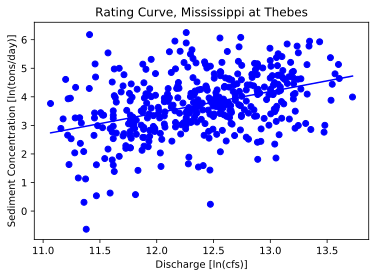

In [9]:
import math
plt.scatter(log_flow_sand,log_sand,c='b')
plt.plot(log_flow_sand,sand_pow[1]+sand_pow[0]*log_flow_sand,'b')
plt.title('Rating Curve, Mississippi at Thebes')
plt.xlabel('Discharge [ln(cfs)]')
plt.ylabel('Sediment Concentration [ln(tons/day)]');
plt.savefig("rating.png")

# Effective Discharge

In [10]:
cumulative_load=[0.0]
discharge=[0.0]
for q,fr in zip(rep_discharge,annual_frequency):
    discharge.append(q)
    cumulative_load.append(cumulative_load[-1]+fr*math.exp(math.log(q)*sand_pow[0]+sand_pow[1]))
percent_cumulative_load = [l/cumulative_load[-1] for l in cumulative_load]

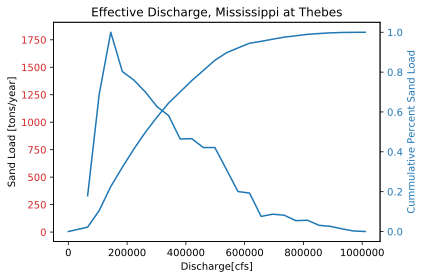

In [11]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Discharge[cfs]')
ax1.set_ylabel('Sand Load [tons/year]')
ax1.plot(rep_discharge, annual_frequency*(np.exp(np.log(rep_discharge)*sand_pow[0]+sand_pow[1])))
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Cummulative Percent Sand Load', color=color)  # we already handled the x-label with ax1
ax2.plot(discharge,percent_cumulative_load)
ax2.tick_params(axis='y', labelcolor=color)
plt.title("Effective Discharge, Mississippi at Thebes")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("effective_discharge.png")